Individual assignment
===
1. Preprocessing
2. Sanity checks
3. First-level analysis

# 0. Setup

## Imports

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from nipype import config

cfg = dict(
    logging=dict(workflow_level="INFO"),
    execution={
        "stop_on_first_crash": "True",
        "hash_method": "content",
        "remove_unnecessary_outputs": "True",
    },
)
config.update_config(cfg)

In [3]:
import os
from os.path import join as opj
import json
from nipype.interfaces.fsl import (
    BET,
    ExtractROI,
    FAST,
    FLIRT,
    ImageMaths,
    MCFLIRT,
    SliceTimer,
    Threshold,
    IsotropicSmooth,
    FLIRT,
    FNIRT,
    ApplyWarp,
)
from nipype.interfaces.fsl.utils import RobustFOV
import nibabel as nib
from nilearn import image, plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

# from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from IPython.display import Image

# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI_GZ


In [4]:
os.environ["FSLOUTPUTTYPE"] = "NIFTI"

## Download data and MNI atlas

In [5]:
# sometimes it's necessary to update gdown
#!pip install gdown --upgrade
#!gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
#!unzip ./ds000102.zip -d ./data
#!rm ./ds000102.zip

In [6]:
os.path.exists("data/ds000102")

True

In [7]:
# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O mniatlas.zip
# !unzip -oq mniatlas.zip -d ${FSLDIR}/data/standard

In [8]:
mni_template = os.path.join(fslpath, "data/standard/MNI152_T1_2mm_brain.nii.gz")

os.path.exists(mni_template)

True

## Experiment parameters

In [9]:
project_root_dir = os.getcwd()
experiment_dir = project_root_dir + "/output"
output_dir = "datasink"
working_dir = "working_dir"
data_dir = project_root_dir + "/data/ds000102"

# list of subject identifiers
subject_list = ["02"]

# list of session identifiers
task_list = ["flanker"]

# Smoothing widths to apply
fwhm = [4]  # [4, 8]

# TR of functional images
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4


# os.environ["FSLOUTPUTTYPE"] = "NIFTI"

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

### Inspect Data

In [10]:
anat = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/anat/sub-{subject_list[0]}_T1w.nii.gz"
)
func = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/func/sub-{subject_list[0]}_task-flanker_run-1_bold.nii.gz"
)

anat_data = anat.get_fdata()
func_data = func.get_fdata()  # [:, :, :, 4:]


# check the shape of the files
print("shape of anat file:", anat_data.shape)
print("shape of func file:", func_data.shape)

print(
    f"\nWe have {func_data.shape[2]} slices with a resolution of {func_data.shape[0]}x{func_data.shape[1]} voxels and {func_data.shape[3]} timepoints"
)

shape of anat file: (176, 256, 256)
shape of func file: (64, 64, 40, 146)

We have 40 slices with a resolution of 64x64 voxels and 146 timepoints


In [11]:
TA = TR - (TR / func_data.shape[2])
print(f"TA: {TA}\nTR: {TR}")

TA: 1.95
TR: 2.0


#### Plot of anatomical image

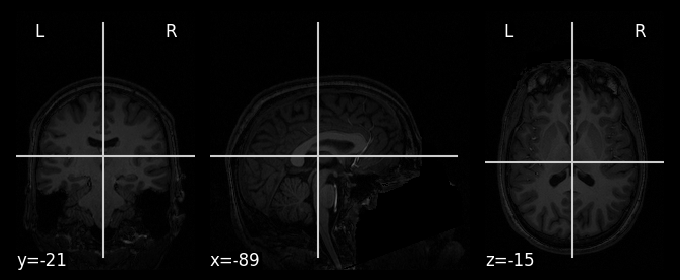

In [12]:
plotting.plot_anat(anat);

#### Plot of functional image

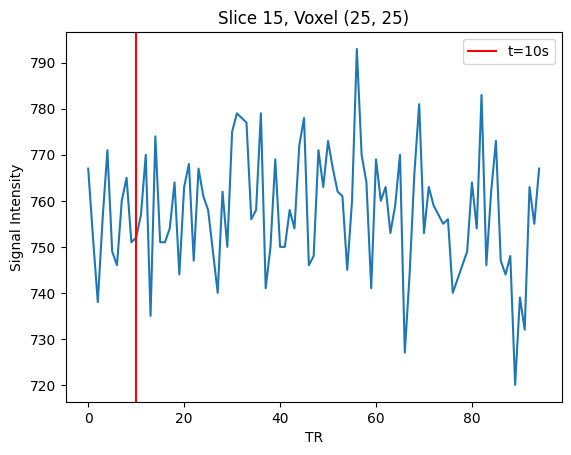

In [13]:
# define variables for number of slices, tr and ta

slice_no = 15
voxel_x = 25
voxel_y = 25

timepoints = slice(5, 100)
timepoint = 10

plt.plot(func_data[slice_no, voxel_x, voxel_y, timepoints])
plt.axvline(timepoint, color="red", label=f"t={timepoint}s")
plt.xlabel("TR")
plt.ylabel("Signal Intensity")
plt.title(f"Slice {slice_no}, Voxel {(voxel_x, voxel_y)}")
plt.legend();

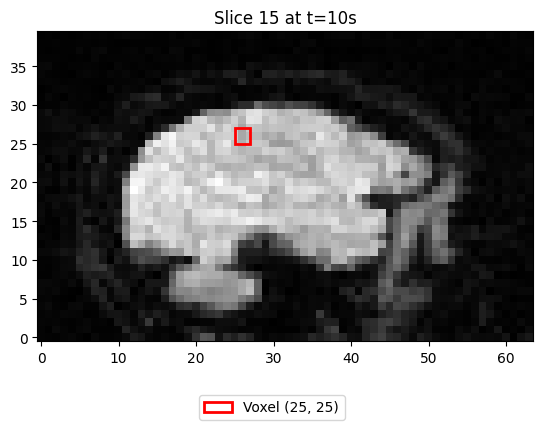

In [14]:
fig, ax = plt.subplots()
ax.imshow(func_data[slice_no, :, :, timepoint].T, cmap="gray", origin="lower")
rect = patches.Rectangle(
    (voxel_x, voxel_y),
    2,
    2,
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label=f"Voxel {(voxel_x, voxel_y)}",
)
ax.add_patch(rect)
ax.set_title(f"Slice {slice_no} at t={timepoint}s")
fig.legend(loc="lower center");

<div class="alert alert-info">everything looks alright</div>

# 1. Preprocessing

## Nodes for main workflow

In [15]:
# ExtractROI - remove first 4 volumes
# extract = Node(ExtractROI(t_min=4, t_size=-1, output_type="NIFTI"), name="extract")
extract = Node(
    ExtractROI(crop_list=[(0, -1), (0, -1), (0, -1), (4, -1)]), name="extract"
)  # alternative

# MCFLIRT - motion correction
mcflirt = Node(
    MCFLIRT(mean_vol=True, save_plots=True, output_type="NIFTI"), name="mcflirt"
)

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(
    SliceTimer(
        index_dir=False, interleaved=True, output_type="NIFTI", time_repetition=TR
    ),
    name="slicetimer",
)

# Smooth - image smoothing
smooth = Node(IsotropicSmooth(), name="smooth")
# smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="art",
)

## Coregistration workflow

221205-12:30:07,488 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


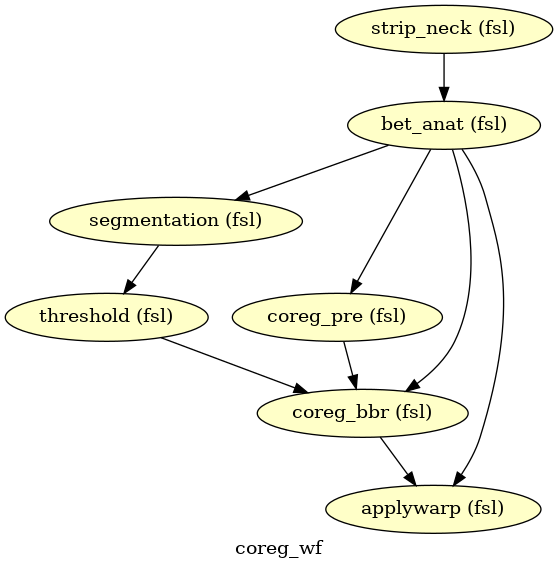

In [16]:
def create_fsl_coregflow(base_directory, apply_to_epis=False):
    """
    Creates FSL like coregistration worfklow

    Returns: Nipype Workflow object
    """

    coreg_wf = Workflow(name="coreg_wf", base_dir=base_directory)

    # Remove neck from anatomical image to improve skullstripping
    strip_neck = Node(RobustFOV(), name="strip_neck")

    # Skullstrip anatomical Image
    bet_anat = Node(
        BET(
            frac=0.2,
            # reduce_bias=True,
            output_type="NIFTI_GZ",
        ),
        name="bet_anat",
    )

    # T1 segmentation & bias field correction
    segmentation = Node(
        FAST(output_type="NIFTI_GZ", output_biascorrected=True),
        name="segmentation",
        mem_gb=4,
    )

    # Threshold WM probability image
    threshold = Node(
        Threshold(thresh=0.15, args="-bin", output_type="NIFTI_GZ"), name="threshold"
    )

    # Pre-alignment of functional images to anatomical images
    coreg_pre = Node(FLIRT(dof=6, output_type="NIFTI_GZ"), name="coreg_pre")

    # Use BBR cost function to improve the coregistration
    coreg_bbr = Node(
        FLIRT(
            dof=6,
            cost="bbr",
            schedule=os.path.join(os.getenv("FSLDIR"), "etc/flirtsch/bbr.sch"),
            output_type="NIFTI_GZ",
        ),
        name="coreg_bbr",
    )

    # Apply coregistration warp to functional images
    applywarp = Node(
        FLIRT(interp="spline", apply_isoxfm=4, output_type="NIFTI"), name="applywarp"
    )

    # connect nodes of coreg workflow
    coreg_wf.connect(
        [
            (strip_neck, bet_anat, [("out_roi", "in_file")]),
            (bet_anat, segmentation, [("out_file", "in_files")]),
            (segmentation, threshold, [(("partial_volume_files", get_wm), "in_file")]),
            (bet_anat, coreg_pre, [("out_file", "reference")]),
            (threshold, coreg_bbr, [("out_file", "wm_seg")]),
            (coreg_pre, coreg_bbr, [("out_matrix_file", "in_matrix_file")]),
            (bet_anat, coreg_bbr, [("out_file", "reference")]),
        ]
    )

    if apply_to_epis:
        coreg_wf.connect(coreg_bbr, "out_matrix_file", applywarp, "in_matrix_file")
        coreg_wf.connect(bet_anat, "out_file", applywarp, "reference")

    return coreg_wf


def get_wm(files):
    """
    Helper function to select WM segmentation file from segmentation output
    """
    return files[-1]


coreg_wf = create_fsl_coregflow(
    base_directory=opj(experiment_dir, working_dir), apply_to_epis=True
)

coreg_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(coreg_wf.base_dir, "coreg_wf", "graph.png"))

## Normalization workflow

221205-12:30:07,651 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


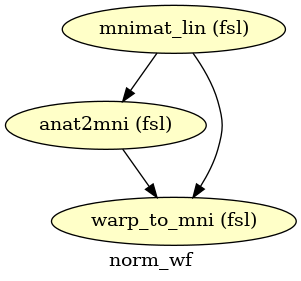

In [17]:
def create_fsl_normflow(base_directory, reference):
    """
    Creates FSL like normalization worfklow

    Returns: Nipype Workflow object
    """

    norm_wf = Workflow(name="norm_wf", base_dir=base_directory)

    # linear transformation of t1 to mni template
    mnimat_lin = Node(
        FLIRT(cost_func="normcorr", dof=12, reference=reference), name="mnimat_lin"
    )

    # non-linear transformation of t1 to mni (using params from linear transf.)
    anat2mni = Node(
        FNIRT(ref_file=reference, warped_file="warped.nii"), name="anat2mni"
    )

    # warp epi data to mni template
    warp_to_mni = Node(ApplyWarp(ref_file=reference), name="warp_to_mni")

    norm_wf.connect(
        [
            (mnimat_lin, anat2mni, [("out_matrix_file", "affine_file")]),
            (anat2mni, warp_to_mni, [("field_file", "field_file")]),
            (mnimat_lin, warp_to_mni, [("out_matrix_file", "postmat")]),
        ]
    )

    return norm_wf


norm_wf = create_fsl_normflow(
    base_directory=opj(experiment_dir, working_dir), reference=mni_template
)

norm_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(norm_wf.base_dir, "norm_wf", "graph.png"))

## IO stream

In [18]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(
    IdentityInterface(fields=["subject_id", "task_name"]), name="infosource"
)
infosource.iterables = [("subject_id", subject_list), ("task_name", task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj(
    "sub-{subject_id}",
    "anat",
    "sub-{subject_id}_T1w.nii.gz",
)
func_file = opj(
    "sub-{subject_id}",
    "func",
    "sub-{subject_id}_task-{task_name}_run-1_bold.nii.gz",
)

templates = {"anat": anat_file, "func": func_file}
selectfiles = Node(SelectFiles(templates, base_directory=data_dir), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(
    DataSink(base_directory=experiment_dir, container=output_dir), name="datasink"
)

## Use the following DataSink output substitutions
substitutions = [
    ("_subject_id_", "sub-"),
    ("_task_name_", "/task-"),
    ("_fwhm_", "fwhm-"),
    ("_roi", ""),
    ("_mcf", ""),
    ("_st", ""),
    ("_flirt", ""),
    (".nii_mean_reg", "_mean"),
    (".nii.par", ".par"),
]
subjFolders = [("fwhm-%s/" % f, "fwhm-%s_" % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Connect main workflow

In [19]:
# Create a preprocessing workflow
preproc_wf = Workflow(name="preproc_wf")
preproc_wf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc_wf.connect(
    [
        (
            infosource,
            selectfiles,
            [("subject_id", "subject_id"), ("task_name", "task_name")],
        ),
        (selectfiles, extract, [("func", "in_file")]),
        (extract, mcflirt, [("roi_file", "in_file")]),
        (mcflirt, slicetimer, [("out_file", "in_file")]),
        (
            selectfiles,
            coreg_wf,
            [
                ("anat", "strip_neck.in_file"),
            ],
        ),
        (
            mcflirt,
            coreg_wf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
            ],
        ),
        (
            slicetimer,
            coreg_wf,
            [("slice_time_corrected_file", "applywarp.in_file")],
        ),
        (
            coreg_wf,
            norm_wf,
            [
                ("segmentation.restored_image", "mnimat_lin.in_file"),
                ("segmentation.restored_image", "anat2mni.in_file"),
                ("applywarp.out_file", "warp_to_mni.in_file"),
            ],
        ),
        (norm_wf, smooth, [("warp_to_mni.out_file", "in_file")]),
        (mcflirt, datasink, [("par_file", "preproc_wf.@par")]),
        (smooth, datasink, [("out_file", "preproc_wf.@smooth")]),
        (coreg_wf, art, [("applywarp.out_file", "realigned_files")]),
        (mcflirt, art, [("par_file", "realignment_parameters")]),
        (
            coreg_wf,
            datasink,
            [
                ("coreg_bbr.out_matrix_file", "preproc_wf.@mat_file"),
                ("bet_anat.out_file", "preproc_wf.@brain"),
            ],
        ),
        (
            norm_wf,
            datasink,
            [
                ("warp_to_mni.out_file", "preproc_wf.@warped_to_mni"),
                ("anat2mni.warped_file", "preproc_wf.@_file"),
            ],
        ),
        (
            art,
            datasink,
            [
                ("outlier_files", "preproc_wf.@outlier_files"),
                ("plot_files", "preproc_wf.@plot_files"),
            ],
        ),
    ]
)

## Visualize the complete workflow

221205-12:30:07,963 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/output/working_dir/preproc_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/output/working_dir/preproc_wf/graph.png (graph2use=colored, simple_form=True).


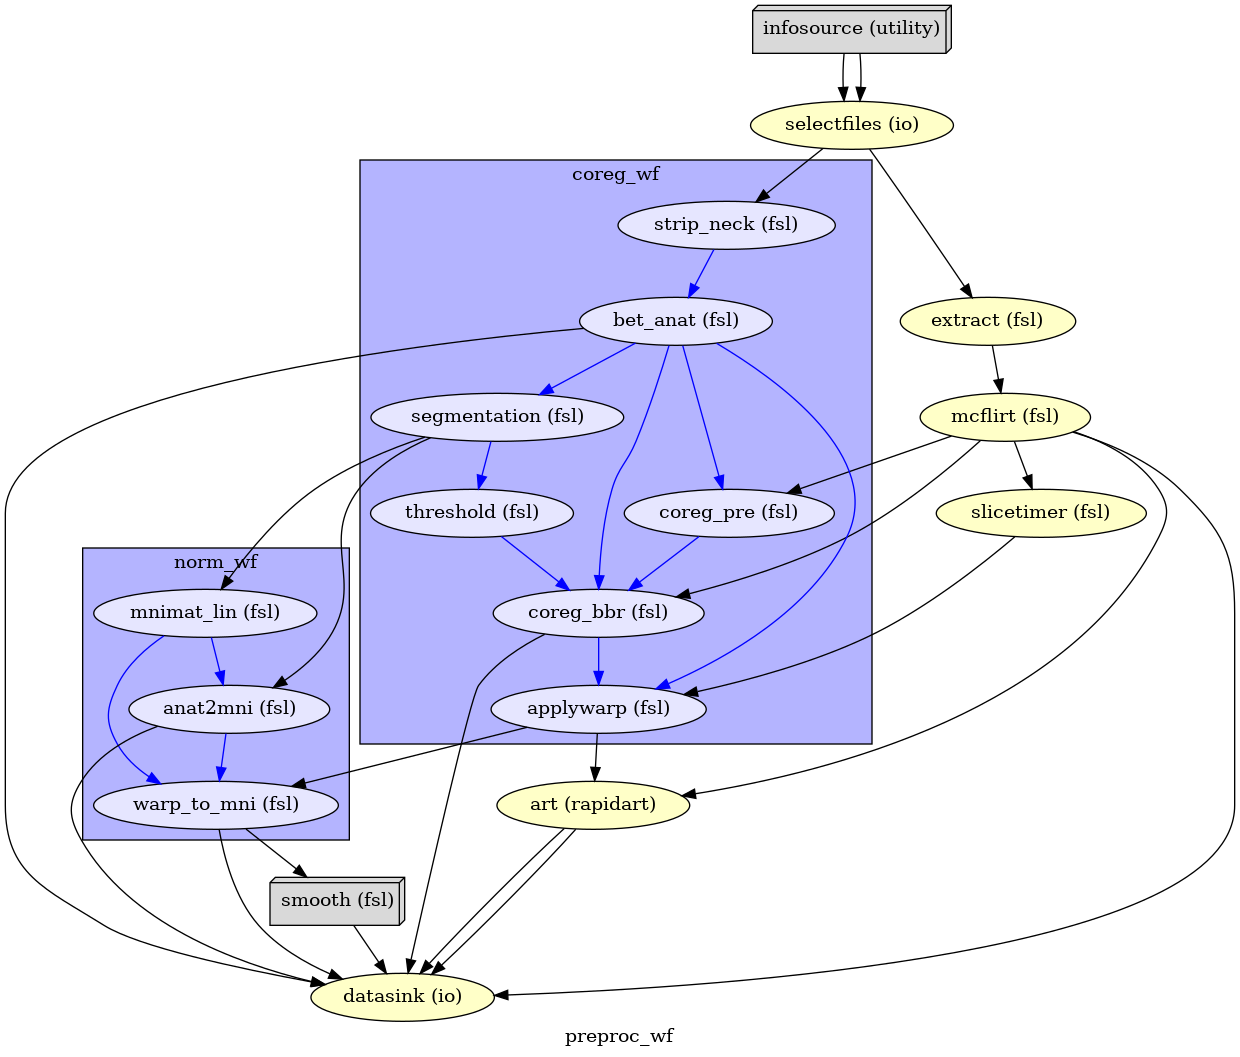

In [20]:
# Create preproc output graph
preproc_wf.write_graph(graph2use="colored", format="png", simple_form=True)

Image(filename=opj(preproc_wf.base_dir, "preproc_wf", "graph.png"))

221205-12:30:08,648 nipype.workflow INFO:
	 Generated workflow graph: /main/assignments/output/working_dir/preproc_wf/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /main/assignments/output/working_dir/preproc_wf/graph.png (graph2use=flat, simple_form=True).


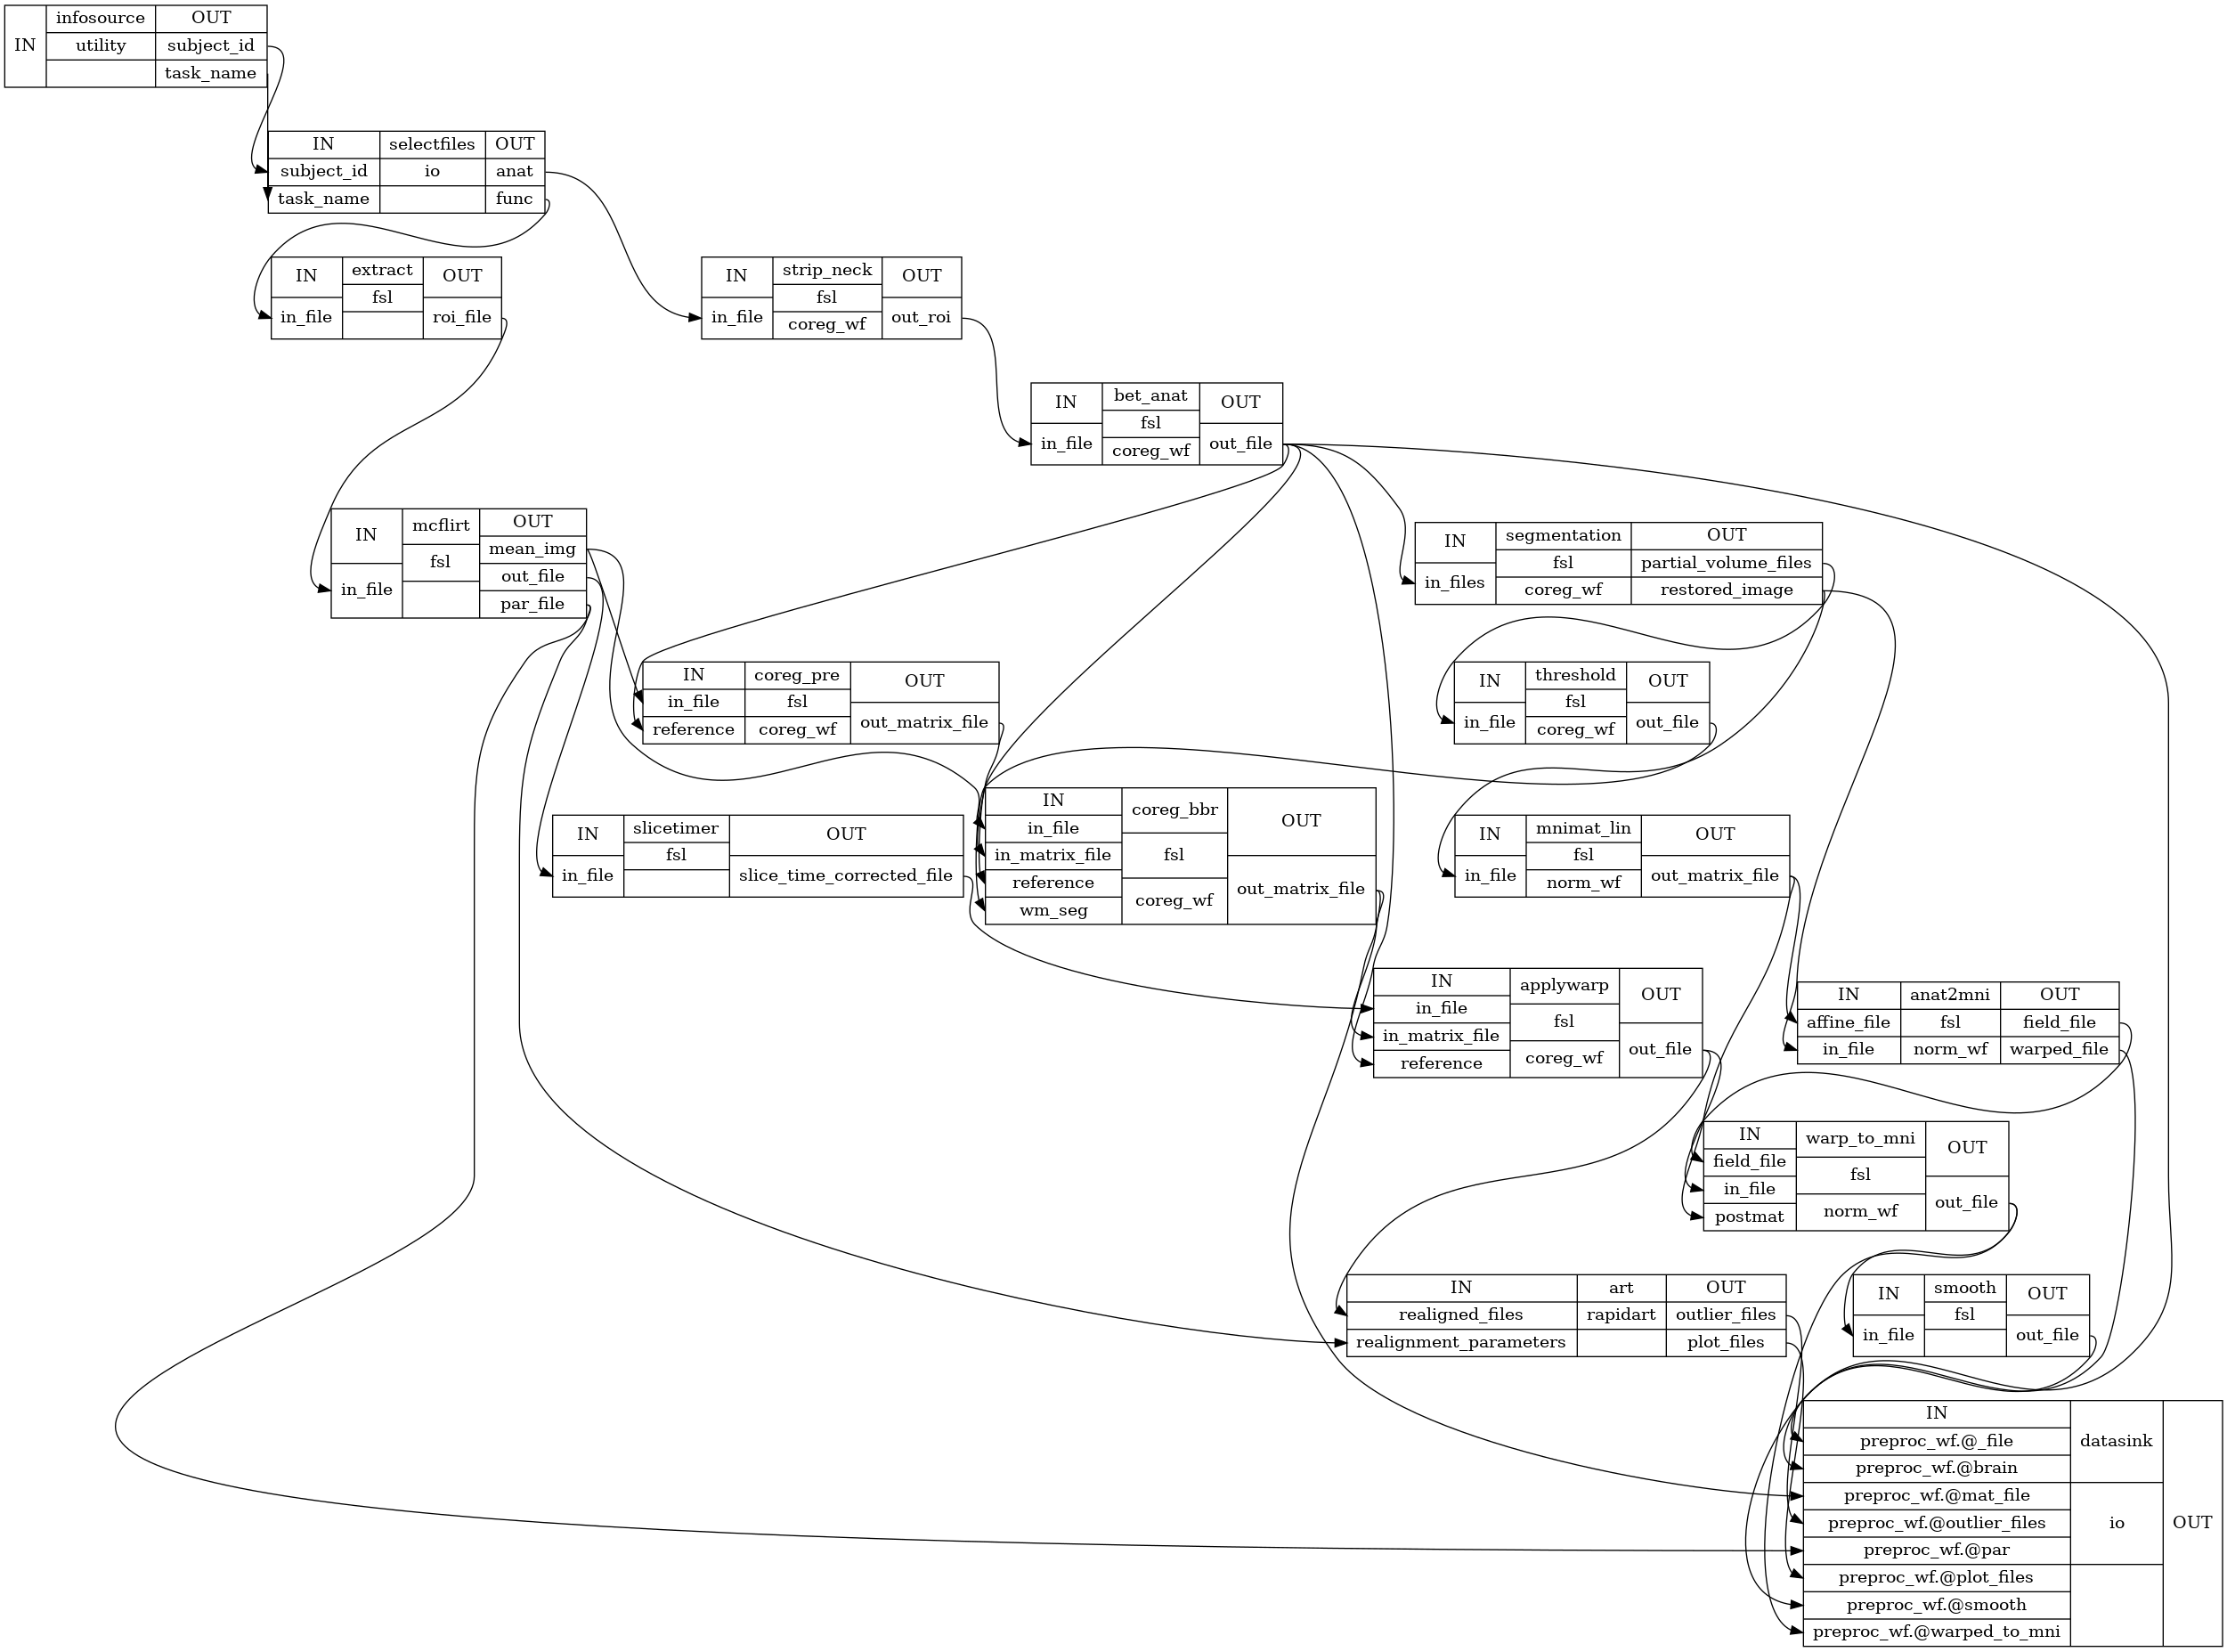

In [21]:
# Visualize the detailed graph
preproc_wf.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=opj(preproc_wf.base_dir, "preproc_wf", "graph_detailed.png"))

## Run workflow

In [ ]:
preproc_wf.run("MultiProc", plugin_args={"n_procs": 8})

221205-12:30:08,701 nipype.workflow INFO:
	 Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow preproc_wf settings: ['check', 'execution', 'logging', 'monitoring']


221205-12:30:08,737 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


221205-12:30:08,742 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 45.13/45.13, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 45.13/45.13, Free processors: 8/8.


221205-12:30:08,873 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.selectfiles" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.selectfiles" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/selectfiles".


221205-12:30:08,881 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221205-12:30:08,888 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001623s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001623s.


221205-12:30:10,744 nipype.workflow INFO:
	 [Job 0] Completed (preproc_wf.selectfiles).


INFO:nipype.workflow:[Job 0] Completed (preproc_wf.selectfiles).


221205-12:30:10,750 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 45.13/45.13, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 45.13/45.13, Free processors: 8/8.


221205-12:30:10,872 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.extract" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract".
221205-12:30:10,873 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.coreg_wf.strip_neck" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/strip_neck".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.extract" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/extract".
INFO:nipype.workflow:[Node] Setting-up "preproc_wf.coreg_wf.strip_neck" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/strip_neck".


221205-12:30:10,920 nipype.workflow INFO:
	 [Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


INFO:nipype.workflow:[Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


221205-12:30:10,986 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


INFO:nipype.workflow:[Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


221205-12:30:12,13 nipype.workflow INFO:
	 [Node] Finished "strip_neck", elapsed time 1.088851s.


INFO:nipype.workflow:[Node] Finished "strip_neck", elapsed time 1.088851s.


221205-12:30:12,80 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 1.089711s.


INFO:nipype.workflow:[Node] Finished "extract", elapsed time 1.089711s.


221205-12:30:12,745 nipype.workflow INFO:
	 [Job 1] Completed (preproc_wf.extract).


INFO:nipype.workflow:[Job 1] Completed (preproc_wf.extract).


221205-12:30:12,747 nipype.workflow INFO:
	 [Job 2] Completed (preproc_wf.coreg_wf.strip_neck).


INFO:nipype.workflow:[Job 2] Completed (preproc_wf.coreg_wf.strip_neck).


221205-12:30:12,751 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 45.13/45.13, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 45.13/45.13, Free processors: 8/8.


221205-12:30:12,822 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.mcflirt" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/mcflirt".
221205-12:30:12,822 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.coreg_wf.bet_anat" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/bet_anat".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.coreg_wf.bet_anat" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/bet_anat".
INFO:nipype.workflow:[Node] Setting-up "preproc_wf.mcflirt" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/mcflirt".


221205-12:30:12,934 nipype.workflow INFO:
	 [Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


INFO:nipype.workflow:[Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


221205-12:30:12,995 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>


INFO:nipype.workflow:[Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>


221205-12:30:14,748 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 44.73/45.13, Free processors: 6/8.
                     Currently running:
                       * preproc_wf.coreg_wf.bet_anat
                       * preproc_wf.mcflirt


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 44.73/45.13, Free processors: 6/8.
                     Currently running:
                       * preproc_wf.coreg_wf.bet_anat
                       * preproc_wf.mcflirt


221205-12:30:15,495 nipype.workflow INFO:
	 [Node] Finished "bet_anat", elapsed time 2.555891s.


INFO:nipype.workflow:[Node] Finished "bet_anat", elapsed time 2.555891s.


221205-12:30:16,749 nipype.workflow INFO:
	 [Job 4] Completed (preproc_wf.coreg_wf.bet_anat).


INFO:nipype.workflow:[Job 4] Completed (preproc_wf.coreg_wf.bet_anat).


221205-12:30:16,753 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 44.93/45.13, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.mcflirt


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 44.93/45.13, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.mcflirt


221205-12:30:16,823 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.coreg_wf.segmentation" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/segmentation".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.coreg_wf.segmentation" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/segmentation".


221205-12:30:16,842 nipype.workflow INFO:
	 [Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


INFO:nipype.workflow:[Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


221205-12:30:18,751 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 40.93/45.13, Free processors: 6/8.
                     Currently running:
                       * preproc_wf.coreg_wf.segmentation
                       * preproc_wf.mcflirt


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 40.93/45.13, Free processors: 6/8.
                     Currently running:
                       * preproc_wf.coreg_wf.segmentation
                       * preproc_wf.mcflirt


221205-12:30:57,906 nipype.workflow INFO:
	 [Node] Finished "mcflirt", elapsed time 44.906127s.


INFO:nipype.workflow:[Node] Finished "mcflirt", elapsed time 44.906127s.


221205-12:30:58,793 nipype.workflow INFO:
	 [Job 3] Completed (preproc_wf.mcflirt).


INFO:nipype.workflow:[Job 3] Completed (preproc_wf.mcflirt).


221205-12:30:58,798 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 2 jobs ready. Free memory (GB): 41.13/45.13, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.coreg_wf.segmentation


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 2 jobs ready. Free memory (GB): 41.13/45.13, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.coreg_wf.segmentation


221205-12:30:58,867 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.slicetimer" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/slicetimer".
221205-12:30:58,867 nipype.workflow INFO:
	 [Node] Setting-up "preproc_wf.coreg_wf.coreg_pre" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/coreg_pre".


INFO:nipype.workflow:[Node] Setting-up "preproc_wf.slicetimer" in "/main/assignments/output/working_dir/preproc_wf/_subject_id_02_task_name_flanker/slicetimer".
INFO:nipype.workflow:[Node] Setting-up "preproc_wf.coreg_wf.coreg_pre" in "/main/assignments/output/working_dir/preproc_wf/coreg_wf/_subject_id_02_task_name_flanker/coreg_pre".


221205-12:30:58,891 nipype.workflow INFO:
	 [Node] Executing "coreg_pre" <nipype.interfaces.fsl.preprocess.FLIRT>


INFO:nipype.workflow:[Node] Executing "coreg_pre" <nipype.interfaces.fsl.preprocess.FLIRT>


221205-12:30:59,44 nipype.workflow INFO:
	 [Node] Executing "slicetimer" <nipype.interfaces.fsl.preprocess.SliceTimer>


INFO:nipype.workflow:[Node] Executing "slicetimer" <nipype.interfaces.fsl.preprocess.SliceTimer>


221205-12:31:00,795 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 0 jobs ready. Free memory (GB): 40.73/45.13, Free processors: 5/8.
                     Currently running:
                       * preproc_wf.coreg_wf.coreg_pre
                       * preproc_wf.slicetimer
                       * preproc_wf.coreg_wf.segmentation


INFO:nipype.workflow:[MultiProc] Running 3 tasks, and 0 jobs ready. Free memory (GB): 40.73/45.13, Free processors: 5/8.
                     Currently running:
                       * preproc_wf.coreg_wf.coreg_pre
                       * preproc_wf.slicetimer
                       * preproc_wf.coreg_wf.segmentation


221205-12:31:03,564 nipype.workflow INFO:
	 [Node] Finished "coreg_pre", elapsed time 4.667933s.


INFO:nipype.workflow:[Node] Finished "coreg_pre", elapsed time 4.667933s.


221205-12:31:04,799 nipype.workflow INFO:
	 [Job 7] Completed (preproc_wf.coreg_wf.coreg_pre).


INFO:nipype.workflow:[Job 7] Completed (preproc_wf.coreg_wf.coreg_pre).


221205-12:31:04,803 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 40.93/45.13, Free processors: 6/8.
                     Currently running:
                       * preproc_wf.slicetimer
                       * preproc_wf.coreg_wf.segmentation


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 40.93/45.13, Free processors: 6/8.
                     Currently running:
                       * preproc_wf.slicetimer
                       * preproc_wf.coreg_wf.segmentation


221205-12:31:05,172 nipype.workflow INFO:
	 [Node] Finished "slicetimer", elapsed time 6.123427s.


INFO:nipype.workflow:[Node] Finished "slicetimer", elapsed time 6.123427s.


221205-12:31:06,801 nipype.workflow INFO:
	 [Job 5] Completed (preproc_wf.slicetimer).


INFO:nipype.workflow:[Job 5] Completed (preproc_wf.slicetimer).


221205-12:31:06,804 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 41.13/45.13, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.coreg_wf.segmentation


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 41.13/45.13, Free processors: 7/8.
                     Currently running:
                       * preproc_wf.coreg_wf.segmentation


# 2. Sanity checks

## Inspect output

In [ ]:
!tree output/datasink

<div class="alert alert-warning">Unfortunately, one of the subworkflows isn't storing the output files in the correct directory, it created another datasink subdirectory.</div>

## Visualize results

Anatomical image

In [ ]:
#%matplotlib inline
out_path = f"output/datasink/preproc_wf/sub-{subject_list[0]}/task-flanker"

plotting.plot_epi(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz"),
    title="Anatomical image",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="gray",
);

Functional image, Mean activation

In [ ]:
plotting.plot_epi(
    image.mean_img(
        opj(
            out_path,
            f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_warp_smooth.nii",
        )
    ),
    title="fwhm = 4mm",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="gray",
);

## Check shape of preprocessed image

In [ ]:
pp_anat = nib.load(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz")
).get_fdata()

print(f"\n Shape of anatomical image: {pp_anat.shape}")

In [ ]:
pp_func = nib.load(
    opj(
        out_path,
        f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_warp_smooth.nii",
    )
).get_fdata()

print(f"\n Shape of functional image: {pp_func.shape}")

## Motion

In [ ]:
par = np.loadtxt(
    "output/datasink/preproc_wf/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par"
)
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel("rotation (radians)")
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel("time (TR)")
axes[1].set_ylabel("translation (mm)");

<div class="alert alert-info">Seems to be an outlier at around volume 75 on the x-axis (rotation)</div>

In [ ]:
outlier_ids = np.loadtxt(
    "output/datasink/preproc_wf/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt"
)
print("Outliers were detected at volumes: %s" % outlier_ids)

from IPython.display import SVG

SVG(
    filename="output/datasink/preproc_wf/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg"
)

## Check normalization

Visualize normalization results by overlaying raw and normalized files with MNI template mask

In [ ]:
#
#
#

# 3. First Level Analysis

Using the preprocessed files, perform a first-level analysis. The steps are:

- Setup Model (using Nilearn's ```FirstLevelModel```)

- Fit the model to the data
  - use the events file stored in the data directory
  - use the motion parameter as confounds
  
  
- Plot the design matrix
- Define the contrasts
  - congruent_correct > baseline
  - incongruent_correct > baseline
  - incongruent-congruent
  - congruent-incongruent
  - motion parameters > baseline
- Calculate a z-statistics map for each contrast
- Plot the z-statistics maps (using the subject's warped anatomical image as background)

In [ ]:
#
#
#